refference 
https://entreprenerdly.com/top-36-moving-averages-methods-for-stock-prices-in-python/
Top 36 Moving Averages Methods For Stock Prices In Python

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from stock_indicators import indicators
from stock_indicators import Quote

In [3]:
dataset = yf.download('NDX', start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'),
                      progress=False,
                      period="ytd", interval="1wk")
dataset = dataset.reset_index()
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-10,9517.860352,9623.580078,9517.860352,9623.580078,9623.580078,0
1,2020-02-17,9629.799805,9718.730469,9446.690430,9446.690430,9446.690430,0
2,2020-02-24,9079.629883,9079.629883,8436.669922,8461.830078,8461.830078,0
3,2020-03-02,8877.980469,8949.280273,8594.490234,8671.660156,8671.660156,0
4,2020-03-09,7948.029785,8372.269531,7263.649902,7995.259766,7995.259766,0
...,...,...,...,...,...,...,...
228,2024-06-24,19474.619141,19789.029297,19474.619141,19682.869141,19682.869141,0
229,2024-07-01,19812.220703,20391.970703,19812.220703,20391.970703,20391.970703,0
230,2024-07-08,20439.539062,20675.380859,20211.359375,20331.490234,20331.490234,0
231,2024-07-15,20386.880859,20398.619141,19522.619141,19522.619141,19522.619141,0


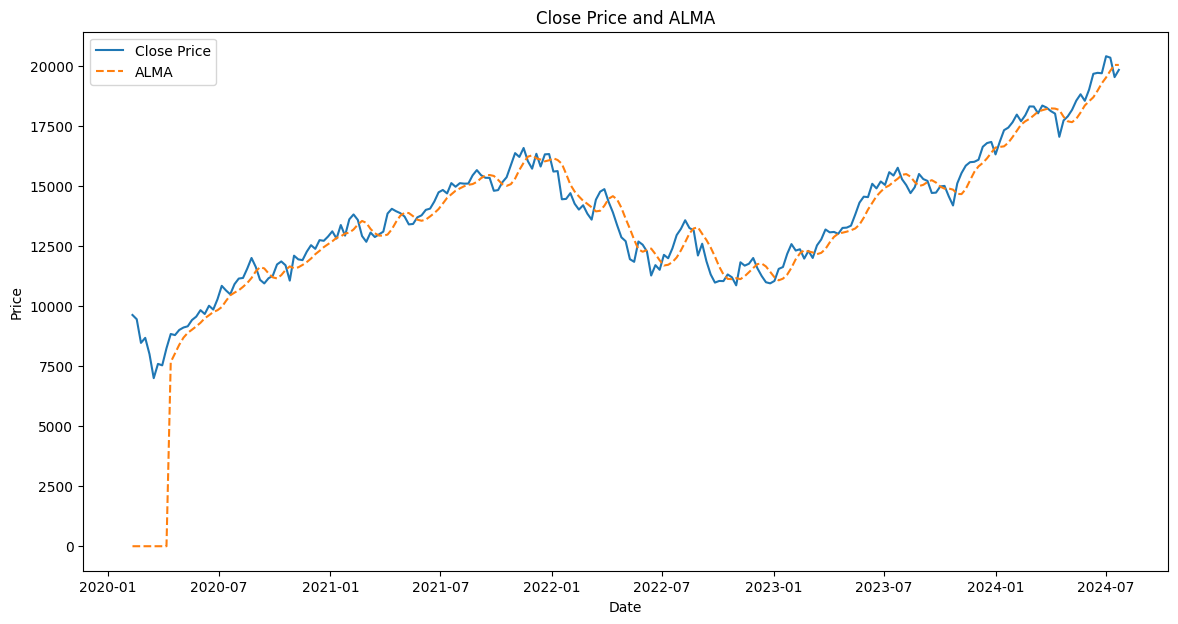

In [4]:
quotes = dataset['Close'].values
lookback_periods = 9
offset = 0.85
sigma = 6

# Step 3: Calculate ALMA
m = offset * (lookback_periods - 1)
s = lookback_periods / sigma
w = [np.exp(-(i - m) ** 2 / (2 * s ** 2)) for i in range(lookback_periods)]
w /= np.sum(w)

alma = np.zeros(len(quotes))
for i in range(lookback_periods, len(quotes)):
    alma[i] = np.dot(quotes[i - lookback_periods:i], w)

# Step 4: Combine ALMA with original dataset
dataset['ALMA'] = alma

# Step 5: Plot the results
plt.figure(figsize=(14, 7))
plt.plot(dataset['Date'], dataset['Close'], label='Close Price')
plt.plot(dataset['Date'], dataset['ALMA'], label='ALMA', linestyle='--')
plt.title('Close Price and ALMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [5]:
# Fractal Adaptive Moving Average (FRAMA)
def fetch_data(ticker_symbol, start_date, end_date):
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    return data


def calculate_FRAMA(data, batch=10):
    # Input
    InputPrice = data['Close'].values

    Length = len(InputPrice)
    Filt = np.array(InputPrice)

    # Sequentially calculate all variables and the output
    for i in range(2 * batch, Length):

        # Take 2 batches of the input
        v1 = InputPrice[i-2*batch:i - batch]
        v2 = InputPrice[i - batch:i]

        # For the 1st batch calculate N1
        H1 = np.max(v1)
        L1 = np.min(v1)
        N1 = (H1 - L1) / batch

        # For the 2nd batch calculate N2
        H2 = np.max(v2)
        L2 = np.min(v2)
        N2 = (H2 - L2) / batch

        # For both batches calculate N3
        H = np.max([H1, H2])
        L = np.min([L1, L2])
        N3 = (H - L) / (2 * batch)

        # Calculate fractal dimension
        Dimen = 0
        if N1 > 0 and N2 > 0 and N3 > 0:
            Dimen = (np.log(N1 + N2) - np.log(N3)) / np.log(2)

        # Calculate lowpass filter factor
        alpha = np.exp(-4.6 * (Dimen) - 1)
        # Ensuring alpha stays between 0.1 and 1
        alpha = np.clip(alpha, 0.1, 1)

        # Filter the input data
        Filt[i] = alpha * InputPrice[i] + (1 - alpha) * Filt[i-1]

    data['FRAMA'] = Filt
    return data


dataset = calculate_FRAMA(dataset)

# Zero Lag Exponential Moving Average (ZLEMA)


def calculate_EMA(prices, period):
    alpha = 2 / (period + 1)
    EMA = [prices[0]]
    for price in prices[1:]:
        EMA.append((price - EMA[-1]) * alpha + EMA[-1])
    return EMA


def calculate_ZLEMA(prices, period):
    lag = period // 2
    adjusted_prices = [
        2*prices[i] - (prices[i - lag] if i >= lag else prices[0]) for i in range(len(prices))]
    ZLEMA = calculate_EMA(adjusted_prices, period)
    return ZLEMA


zlema_period = 28
dataset['ZLEMA'] = calculate_ZLEMA(dataset['Close'].tolist(), zlema_period)

# Variable Index Dynamic Average (VIDYA)


def calculate_CMO(prices, period):
    """ Calculate Chande Momentum Oscillator (CMO) """
    deltas = np.diff(prices)
    sum_gains = np.cumsum(np.where(deltas >= 0, deltas, 0))
    sum_losses = np.abs(np.cumsum(np.where(deltas < 0, deltas, 0)))

    cmo = 100 * (sum_gains - sum_losses) / (sum_gains + sum_losses)
    return np.insert(cmo, 0, 0)  # Add a zero at the beginning for alignment


def calculate_VIDYA(prices, period):
    cmo_values = calculate_CMO(prices, period)
    vidya = [prices[0]]

    for i in range(1, len(prices)):
        alpha = abs(cmo_values[i]) / 100  # Normalize CMO to [0, 1]
        vidya.append((1 - alpha) * vidya[-1] + alpha * prices[i])

    return vidya


vidya_period = 14
dataset['VIDYA'] = calculate_VIDYA(dataset['Close'].tolist(), vidya_period)

# Arnaud Legoux Moving Average (ALMA)


def calculate_ALMA(prices, period, offset=0.85, sigma=6):
    m = np.floor(offset * (period - 1))
    s = period / sigma
    alma = []

    for i in range(period - 1, len(prices)):
        weights = [np.exp(- (j - m)**2 / (2 * s * s)) for j in range(period)]
        sum_weights = sum(weights)
        normalized_weights = [w/sum_weights for w in weights]

        window = prices[i-period+1:i+1]
        alma_value = sum([normalized_weights[j] * window[j]
                         for j in range(period)])
        alma.append(alma_value)

    return [None]*(period-1) + alma


alma_period = 36
dataset['ALMA'] = calculate_ALMA(dataset['Close'].tolist(), alma_period)

# Adaptive Period Moving Average (APMA)


def adaptive_period_moving_average(prices, min_period=5, max_period=30):
    atr = np.zeros_like(prices)
    adjusted_periods = np.zeros_like(prices)
    # Initialize with NaN values
    moving_averages = np.full_like(prices, np.nan)

    for i in range(1, len(prices)):
        atr[i] = atr[i-1] + (abs(prices[i] - prices[i-1]) - atr[i-1]) / 14

        min_volatility = atr[1:i+1].min()
        max_volatility = atr[1:i+1].max()

        if max_volatility == min_volatility:
            adjusted_period = min_period
        else:
            adjusted_period = int(((max_period - min_period) / (
                max_volatility - min_volatility)) * (atr[i] - min_volatility) + min_period)

        adjusted_periods[i] = adjusted_period

        if i >= adjusted_period:
            moving_averages[i] = np.mean(prices[i-adjusted_period+1:i+1])

    return moving_averages


dataset['APMA'] = adaptive_period_moving_average(dataset['Close'].values)

# Wilders Moving Average (WMA)


def wilders_moving_average(prices, period):
    wilder = [prices[0]]
    for price in prices[1:]:
        wilder_value = ((wilder[-1] * (period - 1)) + price) / period
        wilder.append(wilder_value)
    return wilder


period = 14
dataset['Wilders_MA'] = wilders_moving_average(
    dataset['Close'].tolist(), period)

# Smoothed Moving Average (SMMA)


def calculate_SMMA(prices, n):
    SMMA = [np.nan] * (n-1)  # Fill the initial n-1 values with NaN
    SMMA.append(sum(prices[:n]) / n)
    for i in range(n, len(prices)):
        smma_value = (SMMA[-1] * (n - 1) + prices[i]) / n
        SMMA.append(smma_value)
    return SMMA


n = 28
dataset['SMMA'] = calculate_SMMA(dataset['Close'].tolist(), n)

/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_47617/4021902355.py:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset['KAMA'].iloc[i] = dataset['KAMA'].iloc[i-1] + dataset['SC'].iloc[i] * \
/var/folders/jb/ggq229g94ql147w8

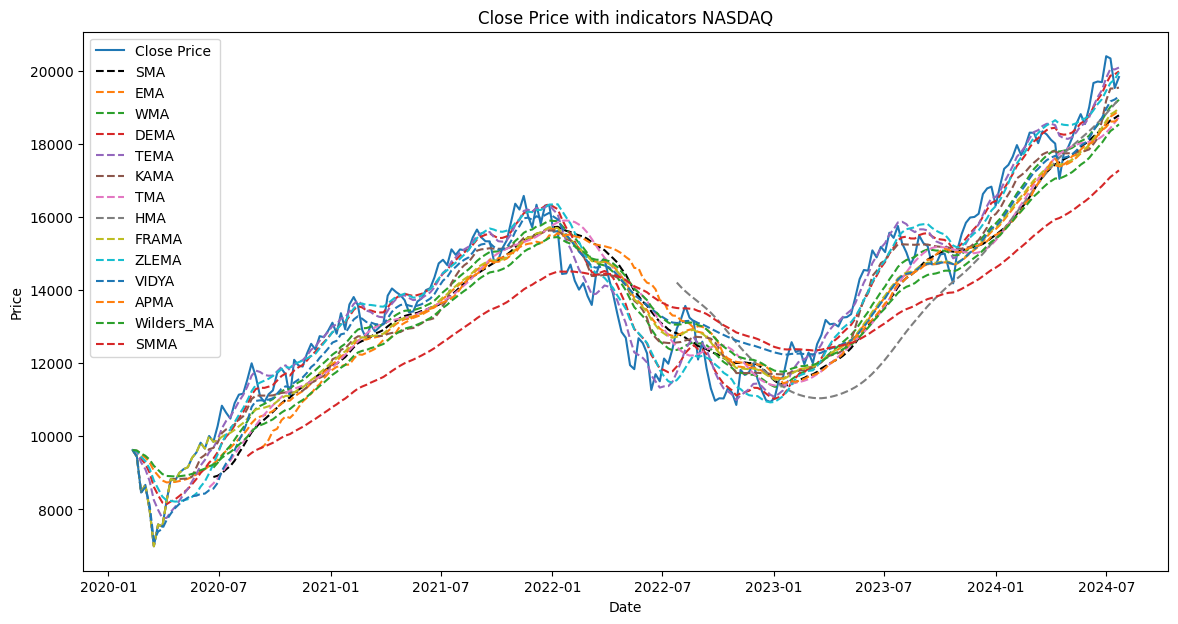

In [6]:

period = 20  # 20 days moving average
dataset['SMA'] = dataset['Close'].rolling(window=period).mean()

dataset['EMA'] = dataset['Close'].ewm(span=period, adjust=False).mean()


weights = np.arange(1, period + 1)
dataset['WMA'] = dataset['Close'].rolling(window=period).apply(
    lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

alpha = 2 / (period + 1)
dataset['EMA2'] = dataset['Close'].ewm(
    span=period, adjust=False).mean().ewm(span=period, adjust=False).mean()
dataset['DEMA'] = 2 * dataset['EMA'] - dataset['EMA2']

alpha = 2 / (period + 1)
dataset['EMA2'] = dataset['Close'].ewm(span=period, adjust=False).mean().ewm(
    span=period, adjust=False).mean()
dataset['EMA3'] = dataset['EMA2'].ewm(span=period, adjust=False).mean()
dataset['TEMA'] = 3 * dataset['EMA'] - 3 * dataset['EMA2'] + dataset['EMA3']


n = 10
fastest_SC = 2 / (2 + 1)
slowest_SC = 2 / (30 + 1)

dataset['Change'] = abs(dataset['Close'] - dataset['Close'].shift(n))
dataset['Volatility'] = dataset['Close'].diff().abs().rolling(window=n).sum()

dataset['ER'] = dataset['Change'] / dataset['Volatility']
dataset['SC'] = (dataset['ER'] * (fastest_SC - slowest_SC) + slowest_SC)**2

dataset['KAMA'] = dataset['Close'].copy()
for i in range(n, len(dataset)):
    dataset['KAMA'].iloc[i] = dataset['KAMA'].iloc[i-1] + dataset['SC'].iloc[i] * \
        (dataset['Close'].iloc[i] - dataset['KAMA'].iloc[i-1])
# Triangular Moving Average (TMA)
n = 20
half_n = (n+1) // 2
dataset['Half_SMA'] = dataset['Close'].rolling(window=half_n).mean()
dataset['TMA'] = dataset['Half_SMA'].rolling(window=half_n).mean()
# Hull Moving Average (HMA)


def weighted_moving_average(data, periods):
    weights = np.arange(1, periods + 1)
    wma = data.rolling(periods).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    return wma


def hull_moving_average(data, periods):
    wma_half_period = weighted_moving_average(data, int(periods / 2))
    wma_full_period = weighted_moving_average(data, periods)
    hma = weighted_moving_average(
        2 * wma_half_period - wma_full_period, int(np.sqrt(periods)))
    return hma


n = 120
dataset['HMA'] = hull_moving_average(dataset['Close'], n)

plt.figure(figsize=(14, 7))
plt.plot(dataset['Date'], dataset['Close'], label='Close Price')
plt.plot(dataset['Date'], dataset['SMA'],
         label='SMA', linestyle='--', color='black')
plt.plot(dataset['Date'], dataset['EMA'], label='EMA', linestyle='--')
plt.plot(dataset['Date'], dataset['WMA'], label='WMA', linestyle='--')
plt.plot(dataset['Date'], dataset['DEMA'], label='DEMA', linestyle='--')
plt.plot(dataset['Date'], dataset['TEMA'], label='TEMA', linestyle='--')
plt.plot(dataset['Date'], dataset['KAMA'], label='KAMA', linestyle='--')
plt.plot(dataset['Date'], dataset['TMA'], label='TMA', linestyle='--')
plt.plot(dataset['Date'], dataset['HMA'], label='HMA', linestyle='--')
plt.plot(dataset['Date'], dataset['FRAMA'], label='FRAMA', linestyle='--')
plt.plot(dataset['Date'], dataset['ZLEMA'], label='ZLEMA', linestyle='--')
plt.plot(dataset['Date'], dataset['VIDYA'], label='VIDYA', linestyle='--')
plt.plot(dataset['Date'], dataset['APMA'], label='APMA', linestyle='--')
plt.plot(dataset['Date'], dataset['Wilders_MA'],
         label='Wilders_MA', linestyle='--')
plt.plot(dataset['Date'], dataset['SMMA'], label='SMMA', linestyle='--')
plt.title('Close Price with indicators NASDAQ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
print(dataset['Close'])

0       9623.580078
1       9446.690430
2       8461.830078
3       8671.660156
4       7995.259766
           ...     
228    19682.869141
229    20391.970703
230    20331.490234
231    19522.619141
232    19822.869141
Name: Close, Length: 233, dtype: float64


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


# Calculate Root Mean Squared Error
rmse_sma = sqrt(mean_squared_error(
    dataset['Close'][-20:], dataset['SMA'][-20:]))
rmse_ema = sqrt(mean_squared_error(dataset['Close'], dataset['EMA']))
rmse_wma = sqrt(mean_squared_error(
    dataset['Close'][-20:], dataset['WMA'][-20:]))
rmse_dema = sqrt(mean_squared_error(dataset['Close'], dataset['DEMA']))
rmse_tema = sqrt(mean_squared_error(dataset['Close'], dataset['TEMA']))


n = 0
# remove VAMA
list_type = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'KAMA',
             'TMA', 'HMA', 'FRAMA', 'ZLEMA', 'VIDYA', 'APMA', 'Wilders_MA', 'SMMA']
rmse_values = []

while (n <= len(list_type)-1):
    rmse = sqrt(mean_squared_error(
        dataset['Close'][-20:], dataset[list_type[n]][-20:]))

    print(n+1, ". RMSE ", list_type[n], " =", rmse)
    rmse_values.append((list_type[n], rmse))
    n += 1

rmse_values.sort(key=lambda x: x[1])
print("****************************************")
for item in rmse_values:
    print(f"RMSE {item[0]} = {item[1]}")

1 . RMSE  SMA  = 1041.3110567397828
2 . RMSE  EMA  = 1053.3562075319287
3 . RMSE  WMA  = 794.0050382455007
4 . RMSE  DEMA  = 455.06917135818173
5 . RMSE  TEMA  = 443.364546973773
6 . RMSE  KAMA  = 827.7185732086024
7 . RMSE  TMA  = 1086.6898069616527
8 . RMSE  HMA  = 866.1470009210014
9 . RMSE  FRAMA  = 1007.4385215912667
10 . RMSE  ZLEMA  = 585.3587411636327
11 . RMSE  VIDYA  = 800.0671542059109
12 . RMSE  APMA  = 1076.2770485645165
13 . RMSE  Wilders_MA  = 1374.4591206913321
14 . RMSE  SMMA  = 2469.4114585820084
****************************************
RMSE TEMA = 443.364546973773
RMSE DEMA = 455.06917135818173
RMSE ZLEMA = 585.3587411636327
RMSE WMA = 794.0050382455007
RMSE VIDYA = 800.0671542059109
RMSE KAMA = 827.7185732086024
RMSE HMA = 866.1470009210014
RMSE FRAMA = 1007.4385215912667
RMSE SMA = 1041.3110567397828
RMSE EMA = 1053.3562075319287
RMSE APMA = 1076.2770485645165
RMSE TMA = 1086.6898069616527
RMSE Wilders_MA = 1374.4591206913321
RMSE SMMA = 2469.4114585820084


In [9]:
n = 0
mae_values = []
while (n <= len(list_type)-1):
    mae = mean_absolute_error(
        dataset['Close'][-20:], dataset[list_type[n]][-20:])

    print(n+1, ". MAE ", list_type[n], " =", mae)
    mae_values.append((list_type[n], mae))
    n += 1

mae_values.sort(key=lambda x: x[1])
print("****************************************")
for item in mae_values:
    print(f"MAE {item[0]} = {item[1]}")

1 . MAE  SMA  = 936.7556982421875
2 . MAE  EMA  = 968.3146609990274
3 . MAE  WMA  = 678.7056566220241
4 . MAE  DEMA  = 362.34555476460355
5 . MAE  TEMA  = 368.22419502540595
6 . MAE  KAMA  = 684.2408903235935
7 . MAE  TMA  = 929.3350205078125
8 . MAE  HMA  = 749.8237050472832
9 . MAE  FRAMA  = 922.3316902992568
10 . MAE  ZLEMA  = 467.0688717924251
11 . MAE  VIDYA  = 716.9930430738066
12 . MAE  APMA  = 969.4953193196145
13 . MAE  Wilders_MA  = 1281.4766010578578
14 . MAE  SMMA  = 2409.9577987654907
****************************************
MAE DEMA = 362.34555476460355
MAE TEMA = 368.22419502540595
MAE ZLEMA = 467.0688717924251
MAE WMA = 678.7056566220241
MAE KAMA = 684.2408903235935
MAE VIDYA = 716.9930430738066
MAE HMA = 749.8237050472832
MAE FRAMA = 922.3316902992568
MAE TMA = 929.3350205078125
MAE SMA = 936.7556982421875
MAE EMA = 968.3146609990274
MAE APMA = 969.4953193196145
MAE Wilders_MA = 1281.4766010578578
MAE SMMA = 2409.9577987654907


In [10]:
# clear data
# rmse_values.clear()
# mae_values.clear()

SegRNN Model 

In [11]:
import torch
import torch.nn as nn
import math


class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()

        # remove this, the performance will be bad
        self.lucky = nn.Embedding(configs.enc_in, configs.d_model // 2)

        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.enc_in = configs.enc_in
        self.patch_len = configs.patch_len
        self.d_model = configs.d_model

        self.linear_patch = nn.Linear(self.patch_len, self.d_model)
        self.relu = nn.ReLU()

        self.gru = nn.GRU(
            input_size=self.d_model,
            hidden_size=self.d_model,
            num_layers=1,
            bias=True,
            batch_first=True,
        )

        self.pos_emb = nn.Parameter(torch.randn(
            self.pred_len // self.patch_len, self.d_model // 2))
        self.channel_emb = nn.Parameter(
            torch.randn(self.enc_in, self.d_model // 2))

        self.dropout = nn.Dropout(configs.dropout)
        self.linear_patch_re = nn.Linear(self.d_model, self.patch_len)

    def forward(self, x, x_mark, y_true, y_mark):
        seq_last = x[:, -1:, :].detach()
        x = x - seq_last

        B, L, C = x.shape
        N = self.seq_len // self.patch_len
        M = self.pred_len // self.patch_len
        W = self.patch_len
        d = self.d_model

        # B, L, C -> B, C, L -> B * C, N, W
        xw = x.permute(0, 2, 1).reshape(B * C, N, -1)
        xd = self.linear_patch(xw)  # B * C, N, W -> B * C, N, d
        enc_in = self.relu(xd)

        # 1, B * C, d -> 1, B * C, M * d -> 1, B * C * M, d
        enc_out = self.gru(enc_in)[1].repeat(1, 1, M).view(1, -1, self.d_model)

        dec_in = torch.cat([
            # M, d//2 -> 1, M, d//2 -> B * C, M, d//2
            self.pos_emb.unsqueeze(0).repeat(B*C, 1, 1),
            # C, d//2 -> C, 1, d//2 -> B * C, M, d//2
            self.channel_emb.unsqueeze(1).repeat(B, M, 1)
            # B * C, M, d -> B * C * M, d -> B * C * M, 1, d
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        dec_out = self.gru(dec_in, enc_out)[0]  # B * C * M, 1, d

        yd = self.dropout(dec_out)
        yw = self.linear_patch_re(yd)  # B * C * M, 1, d -> B * C * M, 1, W
        y = yw.reshape(B, C, -1).permute(0, 2, 1)  # B, C, H

        y = y + seq_last

        return y

In [12]:
import torch
import torch.nn as nn
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from torch.

SyntaxError: invalid syntax (3985828400.py, line 5)